# Introduction 
In this notebook, I re-implement word2vec based on the Wikitext103 dataset.

In [1]:
!pip install -q torchtext lightning datasets
# -q: tùy chọn quiet, sử dụng để giảm thiểu thông tin đầu ra trong quá trình cài đặt

# Prepare dataset 

In [1]:
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset

### Wikitext-103 Dataset
Tập dữ liệu Wikitext-103 là một tập dữ liệu văn bản lớn được trích xuất từ Wikipedia. Nó chứa các bài viết đầy đủ, không bị cắt bớt, với mục tiêu hỗ trợ các nhiệm vụ về xử lý ngôn ngữ tự nhiên (NLP) như mô hình ngôn ngữ (language modeling) và học từ ngữ cảnh (contextual word embeddings).

Cụ thể, wikitext-103-raw-v1 là một phiên bản thô của tập dữ liệu Wikitext-103, nghĩa là các văn bản chưa được tiền xử lý hoặc làm sạch.

In [2]:
from datasets import load_dataset

dataset = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")

print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [15]:
# datapoint 
dataset['train']['text'][100000]

' Governor Mark Sanford declared a state of emergency as Charley approached landfall and issued a mandatory evacuation for residents on barrier islands and in coastal locations in Georgetown and Horry Counties . In Georgetown County , this order was focused on residents and tourists east of U.S. Route 17 , likewise for Horry County . 180 @,@ 000 people evacuated the Grand Strand . Drawbridges in Beaufort and Charleston Counties were shut down , and bridges in Georgetown and Horry Counties were locked down . Hampton County requested 2 @,@ 000 sandbags , that were provided by the Department of Corrections . The Wateree Correctional Institution also filled 30 @,@ 000 sandbags for potential floods . State troopers directed traffic inland from Myrtle Beach . U.S. Route 501 used a lane reversal to allow for evacuations . \n'

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from collections import Counter # đếm tần số xuất hiện của các từ
import re # làm việc với biểu thức chính quy
import random 
import torch


sw = stopwords.words('english') # Danh sách các từ dừng (stop words) trong tiếng Anh.
ss  = SnowballStemmer('english') # Bộ tách gốc từ (stemmer) Snowball cho tiếng Anh.


class WikitextDataset(Dataset): 
    """
    __init__:
        - Khởi tạo tập dữ liệu, kích thước cửa sổ, và xử lý token hóa dữ liệu.
        - Tạo từ điển từ vựng (vocab) từ các token đã qua xử lý.
        - Tạo cửa sổ di chuyển (moving window) để tạo các cặp target-context.
    """
    def __init__(self, dataset, window_size: int = 2,max_samples: int = None): 
        self.dataset = dataset 
        self.window_size = window_size

        if max_samples:
            self.dataset = self.dataset.select(range(max_samples))
        self.dataset = self.dataset.map(self.tokenizer)
        self.create_vocab()
        self.dataset = self.dataset.map(self.windowizer)
        self.moving_window = [i for s in self.dataset['moving_window'] for i in s]
        
    def __len__(self): 
        return len(self.dataset)
    
    """Trả về cặp target-context tại vị trí chỉ số idx."""
    def __getitem__(self, idx: int):
        return self.moving_window[idx]
        
    
    
    def tokenizer(self, row): 
        """
        Hàm này thực hiện chuyển đổi dữ liệu text thành list các token 
        """
        # preprocessing data 
        row['all_tokens'] = [ss.stem(i) for i in       
                     re.split(r" +",               
                     re.sub(r"[^a-z@# ]", "",     
                            row['text'].lower())) # 1
                     if (i not in sw) and len(i)]  # 4
        return row
    
    def create_vocab(self):  

        counts = Counter([i for s in self.dataset['all_tokens'] for i in s])
        counts = {k:v for k, v in counts.items() if v>10} # Filtering
        self.vocab = list(counts.keys())
        self.n_v = len(self.vocab)
        self.id2tok = dict(enumerate(self.vocab))
        self.tok2id = {token: id for id, token in self.id2tok.items()}
        
    def windowizer(self, row): 
        """
        Hàm này phân tách các token thành 2 phần tensor có dạng target và context 
        """
        row['tokens'] = [t for t in row['all_tokens'] if t in self.vocab]
        doc = row['tokens']
        out = []
        for i, wd in enumerate(doc):
            target = self.tok2id[wd]
            window = [i+j for j in
                      range(-self.window_size, self.window_size+1, 1)
                      if (i+j>=0) &
                         (i+j<len(doc)) &
                         (j!=0)]

            out+=[(target, self.tok2id[doc[w]]) for w in window]
        row['moving_window'] = out
        return row

In [6]:
max_samples = 10000
train_data = WikitextDataset(dataset['train'],max_samples=max_samples)

In [7]:
train_data[0]

[0, 1]

In [8]:
# max_samples = 100000
valid_data = WikitextDataset(dataset['validation'])

In [9]:
# dataloader

train_loader = DataLoader(
    train_data,
    batch_size = 32, 
    shuffle = True, 
    
)


valid_loader = DataLoader(
    valid_data, 
    batch_size = 32, 
    shuffle = True
)

next(iter(train_loader))

[tensor([714, 305, 216, 747,   1, 747, 493,  28, 599, 606,  39,  61, 681, 664,
           0,  21, 266, 457,  15, 404, 773, 607, 808,  65, 838,   1, 374,  15,
           1,  21, 466, 318]),
 tensor([713,  46, 217, 460, 138, 747, 491, 124, 176, 604, 342, 173, 633, 331,
         398,   2, 235,   1, 336, 673, 771, 240, 240, 228, 839,   0, 686, 118,
           0, 385, 388, 853])]

# Building model

In [10]:
class SkipModel(nn.Module): 
    
    def __init__(self, vocab_size: int, embedding_size: int):
        super(SkipModel, self).__init__()
        self.model = nn.Sequential(
            nn.Embedding(
                num_embeddings = vocab_size, 
                embedding_dim = embedding_size
            ), 
            nn.Linear(
                in_features = embedding_size, 
                out_features = vocab_size, 
                bias = False
            )
        )
    
    def forward(self, x):
        return self.model(x)
        

In [12]:
vocab = train_data.vocab
vocab_size = len(vocab)

skipmodel = SkipModel(vocab_size, 300)

In [13]:
skipmodel

SkipModel(
  (model): Sequential(
    (0): Embedding(3837, 300)
    (1): Linear(in_features=300, out_features=3837, bias=False)
  )
)

In [12]:
for name, params in skipmodel.named_parameters():
    print(name, ":", params.shape)

model.0.weight : torch.Size([2176, 300])
model.1.weight : torch.Size([2176, 300])


# Training model

In [20]:
import torch.optim as optim


config =  {
        "train_batch_size": 2,
        "val_batch_size": 2,
        "shuffle": True,
        "learning_rate": 1e-3,
        "epochs": 300,
        "train_steps":1, 
        "val_steps":1, 
        "checkpoint_frequency": 20
        }



loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(skipmodel.parameters(), lr = config['learning_rate'])
device = "cuda" if torch.cuda.is_available() else "cpu"
device





'cuda'

In [21]:
# training 
import lightning as L 
from tqdm import tqdm
import numpy as np
import os



class Trainer: 
    def __init__(self, model, loss_fn, vocab, dataloader,  optimizer, device, config): 
        self.model = model.to(device)
        self.loss_fn = loss_fn 
        self.optimizer = optimizer
        self.device = device
        self.config = config 
        self.vocab = vocab 
        self.dataloader = dataloader 
        self.loss = {
            "train" : [], 
            "val": []
        }
        
    
    def train(self): 
        
        for epoch in tqdm(range(self.config['epochs'])): 
            self.train_step()
            self.val_step()
            
            print(
                "Epoch: {}/{}, Train Loss={:.5f}, Val Loss={:.5f}".format(
                    epoch + 1,
                    self.config["epochs"],
                    self.loss["train"][-1],
                    self.loss["val"][-1],
                )
            )
             # Save the model at specified checkpoint frequency
            # if (epoch + 1) % self.config['checkpoint_frequency'] == 0:
            #     self.save_model(f'checkpoint_epoch_{epoch + 1}.pt')
            
    def train_step(self): 
        running_loss = []
        for idx, batch in enumerate(self.dataloader, 1): 
            
            x, y = batch[0], batch[1]
            x, y = x.to(self.device), y.to(self.device)
            
            
            y_pred = self.model(x)
            loss = self.loss_fn(y_pred, y)
            
        
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            running_loss.append([loss.item()])
        self.loss['train'].append(np.mean(running_loss))
        
        
    def val_step(self): 
        val_losses = []
        
        self.model.eval()
        with torch.inference_mode(): 
            for idx, batch in enumerate(self.dataloader, 1): 
                x = batch[0].to(self.device)
                y = batch[1].to(self.device)
                
                y_pred = self.model(x)
                
                loss = self.loss_fn(y_pred, y)
                
                val_losses.append(loss.item())
                
        self.loss['val'].append(np.mean(val_losses))     
                
    def save_model(self, save_path): 
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')
            
    
    

In [22]:
trainer = Trainer(skipmodel, loss_fn, vocab, train_loader, optimizer, device, config)

trainer.train()

  0%|          | 1/300 [00:00<01:47,  2.79it/s]

Epoch: 1/300, Train Loss=3.33907, Val Loss=2.80324


  1%|          | 2/300 [00:00<01:38,  3.03it/s]

Epoch: 2/300, Train Loss=3.24685, Val Loss=2.80601


  1%|          | 3/300 [00:00<01:35,  3.11it/s]

Epoch: 3/300, Train Loss=3.24617, Val Loss=2.80559


  1%|▏         | 4/300 [00:01<01:34,  3.12it/s]

Epoch: 4/300, Train Loss=3.24733, Val Loss=2.80467


  2%|▏         | 5/300 [00:01<01:35,  3.10it/s]

Epoch: 5/300, Train Loss=3.24765, Val Loss=2.80415


  2%|▏         | 6/300 [00:01<01:35,  3.07it/s]

Epoch: 6/300, Train Loss=3.24621, Val Loss=2.80570


  2%|▏         | 7/300 [00:02<01:34,  3.12it/s]

Epoch: 7/300, Train Loss=3.24510, Val Loss=2.80478


  3%|▎         | 8/300 [00:02<01:33,  3.12it/s]

Epoch: 8/300, Train Loss=3.24290, Val Loss=2.80387


  3%|▎         | 9/300 [00:02<01:32,  3.13it/s]

Epoch: 9/300, Train Loss=3.24273, Val Loss=2.80353


  3%|▎         | 10/300 [00:03<01:33,  3.10it/s]

Epoch: 10/300, Train Loss=3.24015, Val Loss=2.80302


  4%|▎         | 11/300 [00:03<01:34,  3.07it/s]

Epoch: 11/300, Train Loss=3.24251, Val Loss=2.80156


  4%|▍         | 12/300 [00:03<01:33,  3.09it/s]

Epoch: 12/300, Train Loss=3.23903, Val Loss=2.80120


  4%|▍         | 13/300 [00:04<01:32,  3.10it/s]

Epoch: 13/300, Train Loss=3.23743, Val Loss=2.80204


  5%|▍         | 14/300 [00:04<01:31,  3.12it/s]

Epoch: 14/300, Train Loss=3.23689, Val Loss=2.80002


  5%|▌         | 15/300 [00:04<01:32,  3.09it/s]

Epoch: 15/300, Train Loss=3.23556, Val Loss=2.79913


  5%|▌         | 16/300 [00:05<01:31,  3.09it/s]

Epoch: 16/300, Train Loss=3.23584, Val Loss=2.80065


  6%|▌         | 17/300 [00:05<01:31,  3.09it/s]

Epoch: 17/300, Train Loss=3.23447, Val Loss=2.80123


  6%|▌         | 18/300 [00:05<01:32,  3.04it/s]

Epoch: 18/300, Train Loss=3.23344, Val Loss=2.80047


  6%|▋         | 19/300 [00:06<01:32,  3.03it/s]

Epoch: 19/300, Train Loss=3.23421, Val Loss=2.79753


  7%|▋         | 20/300 [00:06<01:33,  3.00it/s]

Epoch: 20/300, Train Loss=3.23283, Val Loss=2.79935


  7%|▋         | 21/300 [00:06<01:34,  2.96it/s]

Epoch: 21/300, Train Loss=3.23118, Val Loss=2.79558


  7%|▋         | 22/300 [00:07<01:33,  2.96it/s]

Epoch: 22/300, Train Loss=3.23176, Val Loss=2.79446


  8%|▊         | 23/300 [00:07<01:34,  2.95it/s]

Epoch: 23/300, Train Loss=3.23115, Val Loss=2.79614


  8%|▊         | 24/300 [00:07<01:35,  2.89it/s]

Epoch: 24/300, Train Loss=3.22903, Val Loss=2.79538


  8%|▊         | 25/300 [00:08<01:35,  2.87it/s]

Epoch: 25/300, Train Loss=3.22857, Val Loss=2.79718


  9%|▊         | 26/300 [00:08<01:34,  2.91it/s]

Epoch: 26/300, Train Loss=3.22759, Val Loss=2.79577


  9%|▉         | 27/300 [00:08<01:33,  2.90it/s]

Epoch: 27/300, Train Loss=3.22874, Val Loss=2.79457


  9%|▉         | 28/300 [00:09<01:33,  2.91it/s]

Epoch: 28/300, Train Loss=3.22462, Val Loss=2.79590


 10%|▉         | 29/300 [00:09<01:34,  2.87it/s]

Epoch: 29/300, Train Loss=3.22477, Val Loss=2.79540


 10%|█         | 30/300 [00:10<01:35,  2.82it/s]

Epoch: 30/300, Train Loss=3.22365, Val Loss=2.79704


 10%|█         | 31/300 [00:10<01:35,  2.81it/s]

Epoch: 31/300, Train Loss=3.22634, Val Loss=2.79563


 11%|█         | 32/300 [00:10<01:33,  2.88it/s]

Epoch: 32/300, Train Loss=3.22489, Val Loss=2.79474


 11%|█         | 33/300 [00:11<01:32,  2.90it/s]

Epoch: 33/300, Train Loss=3.22369, Val Loss=2.79291


 11%|█▏        | 34/300 [00:11<01:31,  2.89it/s]

Epoch: 34/300, Train Loss=3.22265, Val Loss=2.79161


 12%|█▏        | 35/300 [00:11<01:31,  2.91it/s]

Epoch: 35/300, Train Loss=3.22064, Val Loss=2.79288


 12%|█▏        | 36/300 [00:12<01:29,  2.95it/s]

Epoch: 36/300, Train Loss=3.22263, Val Loss=2.79317


 12%|█▏        | 37/300 [00:12<01:30,  2.90it/s]

Epoch: 37/300, Train Loss=3.22208, Val Loss=2.79286


 13%|█▎        | 38/300 [00:12<01:30,  2.88it/s]

Epoch: 38/300, Train Loss=3.21965, Val Loss=2.79202


 13%|█▎        | 39/300 [00:13<01:30,  2.89it/s]

Epoch: 39/300, Train Loss=3.21748, Val Loss=2.79291


 13%|█▎        | 40/300 [00:13<01:29,  2.91it/s]

Epoch: 40/300, Train Loss=3.21848, Val Loss=2.78988


 14%|█▎        | 41/300 [00:13<01:29,  2.88it/s]

Epoch: 41/300, Train Loss=3.21820, Val Loss=2.79093


 14%|█▍        | 42/300 [00:14<01:29,  2.90it/s]

Epoch: 42/300, Train Loss=3.21734, Val Loss=2.79107


 14%|█▍        | 43/300 [00:14<01:29,  2.88it/s]

Epoch: 43/300, Train Loss=3.21637, Val Loss=2.79044


 15%|█▍        | 44/300 [00:14<01:28,  2.91it/s]

Epoch: 44/300, Train Loss=3.21651, Val Loss=2.79147


 15%|█▌        | 45/300 [00:15<01:28,  2.89it/s]

Epoch: 45/300, Train Loss=3.21406, Val Loss=2.78993


 15%|█▌        | 46/300 [00:15<01:27,  2.89it/s]

Epoch: 46/300, Train Loss=3.21433, Val Loss=2.79200


 16%|█▌        | 47/300 [00:15<01:27,  2.88it/s]

Epoch: 47/300, Train Loss=3.21586, Val Loss=2.78903


 16%|█▌        | 48/300 [00:16<01:26,  2.90it/s]

Epoch: 48/300, Train Loss=3.21269, Val Loss=2.78915


 16%|█▋        | 49/300 [00:16<01:26,  2.91it/s]

Epoch: 49/300, Train Loss=3.21344, Val Loss=2.78918


 17%|█▋        | 50/300 [00:16<01:25,  2.91it/s]

Epoch: 50/300, Train Loss=3.21163, Val Loss=2.79043


 17%|█▋        | 51/300 [00:17<01:25,  2.92it/s]

Epoch: 51/300, Train Loss=3.21127, Val Loss=2.78855


 17%|█▋        | 52/300 [00:17<01:25,  2.88it/s]

Epoch: 52/300, Train Loss=3.21017, Val Loss=2.78727


 18%|█▊        | 53/300 [00:17<01:27,  2.81it/s]

Epoch: 53/300, Train Loss=3.21001, Val Loss=2.78760


 18%|█▊        | 54/300 [00:18<01:26,  2.84it/s]

Epoch: 54/300, Train Loss=3.20898, Val Loss=2.78841


 18%|█▊        | 55/300 [00:18<01:24,  2.90it/s]

Epoch: 55/300, Train Loss=3.20834, Val Loss=2.78538


 19%|█▊        | 56/300 [00:18<01:23,  2.93it/s]

Epoch: 56/300, Train Loss=3.20660, Val Loss=2.78722


 19%|█▉        | 57/300 [00:19<01:22,  2.96it/s]

Epoch: 57/300, Train Loss=3.20700, Val Loss=2.78880


 19%|█▉        | 58/300 [00:19<01:20,  2.99it/s]

Epoch: 58/300, Train Loss=3.20533, Val Loss=2.78865


 20%|█▉        | 59/300 [00:19<01:19,  3.02it/s]

Epoch: 59/300, Train Loss=3.20639, Val Loss=2.78654


 20%|██        | 60/300 [00:20<01:19,  3.03it/s]

Epoch: 60/300, Train Loss=3.20675, Val Loss=2.78807


 20%|██        | 61/300 [00:20<01:19,  3.00it/s]

Epoch: 61/300, Train Loss=3.20398, Val Loss=2.78706


 21%|██        | 62/300 [00:20<01:19,  3.00it/s]

Epoch: 62/300, Train Loss=3.20573, Val Loss=2.78716


 21%|██        | 63/300 [00:21<01:18,  3.00it/s]

Epoch: 63/300, Train Loss=3.20411, Val Loss=2.78591


 21%|██▏       | 64/300 [00:21<01:18,  3.00it/s]

Epoch: 64/300, Train Loss=3.20489, Val Loss=2.78615


 22%|██▏       | 65/300 [00:21<01:18,  2.99it/s]

Epoch: 65/300, Train Loss=3.20572, Val Loss=2.78851


 22%|██▏       | 66/300 [00:22<01:19,  2.96it/s]

Epoch: 66/300, Train Loss=3.20224, Val Loss=2.78613


 22%|██▏       | 67/300 [00:22<01:17,  2.99it/s]

Epoch: 67/300, Train Loss=3.20306, Val Loss=2.78637


 23%|██▎       | 68/300 [00:22<01:17,  2.99it/s]

Epoch: 68/300, Train Loss=3.20140, Val Loss=2.78490


 23%|██▎       | 69/300 [00:23<01:18,  2.96it/s]

Epoch: 69/300, Train Loss=3.20177, Val Loss=2.78349


 23%|██▎       | 70/300 [00:23<01:18,  2.94it/s]

Epoch: 70/300, Train Loss=3.19938, Val Loss=2.78382


 24%|██▎       | 71/300 [00:23<01:17,  2.95it/s]

Epoch: 71/300, Train Loss=3.19935, Val Loss=2.78480


 24%|██▍       | 72/300 [00:24<01:17,  2.96it/s]

Epoch: 72/300, Train Loss=3.19888, Val Loss=2.78485


 24%|██▍       | 73/300 [00:24<01:17,  2.92it/s]

Epoch: 73/300, Train Loss=3.19811, Val Loss=2.78621


 25%|██▍       | 74/300 [00:25<01:16,  2.95it/s]

Epoch: 74/300, Train Loss=3.19756, Val Loss=2.78476


 25%|██▌       | 75/300 [00:25<01:15,  2.96it/s]

Epoch: 75/300, Train Loss=3.19692, Val Loss=2.78380


 25%|██▌       | 76/300 [00:25<01:16,  2.93it/s]

Epoch: 76/300, Train Loss=3.19777, Val Loss=2.78467


 26%|██▌       | 77/300 [00:26<01:17,  2.89it/s]

Epoch: 77/300, Train Loss=3.19635, Val Loss=2.78391


 26%|██▌       | 78/300 [00:26<01:16,  2.90it/s]

Epoch: 78/300, Train Loss=3.19606, Val Loss=2.78423


 26%|██▋       | 79/300 [00:26<01:15,  2.92it/s]

Epoch: 79/300, Train Loss=3.19717, Val Loss=2.78370


 27%|██▋       | 80/300 [00:27<01:14,  2.97it/s]

Epoch: 80/300, Train Loss=3.19523, Val Loss=2.78518


 27%|██▋       | 81/300 [00:27<01:13,  2.97it/s]

Epoch: 81/300, Train Loss=3.19434, Val Loss=2.78373


 27%|██▋       | 82/300 [00:27<01:14,  2.94it/s]

Epoch: 82/300, Train Loss=3.19534, Val Loss=2.78170


 28%|██▊       | 83/300 [00:28<01:13,  2.94it/s]

Epoch: 83/300, Train Loss=3.19266, Val Loss=2.78371


 28%|██▊       | 84/300 [00:28<01:13,  2.93it/s]

Epoch: 84/300, Train Loss=3.19331, Val Loss=2.78341


 28%|██▊       | 85/300 [00:28<01:13,  2.94it/s]

Epoch: 85/300, Train Loss=3.19077, Val Loss=2.78344


 29%|██▊       | 86/300 [00:29<01:11,  2.97it/s]

Epoch: 86/300, Train Loss=3.19130, Val Loss=2.78391


 29%|██▉       | 87/300 [00:29<01:11,  2.99it/s]

Epoch: 87/300, Train Loss=3.19003, Val Loss=2.78373


 29%|██▉       | 88/300 [00:29<01:10,  3.00it/s]

Epoch: 88/300, Train Loss=3.19037, Val Loss=2.78323


 30%|██▉       | 89/300 [00:30<01:10,  2.99it/s]

Epoch: 89/300, Train Loss=3.19013, Val Loss=2.78235


 30%|███       | 90/300 [00:30<01:10,  2.99it/s]

Epoch: 90/300, Train Loss=3.19227, Val Loss=2.77953


 30%|███       | 91/300 [00:30<01:09,  3.01it/s]

Epoch: 91/300, Train Loss=3.18796, Val Loss=2.78278


 31%|███       | 92/300 [00:31<01:09,  2.98it/s]

Epoch: 92/300, Train Loss=3.18900, Val Loss=2.78274


 31%|███       | 93/300 [00:31<01:10,  2.95it/s]

Epoch: 93/300, Train Loss=3.18844, Val Loss=2.78220


 31%|███▏      | 94/300 [00:31<01:09,  2.95it/s]

Epoch: 94/300, Train Loss=3.18819, Val Loss=2.78054


 32%|███▏      | 95/300 [00:32<01:09,  2.96it/s]

Epoch: 95/300, Train Loss=3.18647, Val Loss=2.78328


 32%|███▏      | 96/300 [00:32<01:09,  2.93it/s]

Epoch: 96/300, Train Loss=3.18731, Val Loss=2.78225


 32%|███▏      | 97/300 [00:32<01:09,  2.93it/s]

Epoch: 97/300, Train Loss=3.18529, Val Loss=2.78144


 33%|███▎      | 98/300 [00:33<01:08,  2.97it/s]

Epoch: 98/300, Train Loss=3.18533, Val Loss=2.78156


 33%|███▎      | 99/300 [00:33<01:08,  2.94it/s]

Epoch: 99/300, Train Loss=3.18435, Val Loss=2.78241


 33%|███▎      | 100/300 [00:33<01:09,  2.89it/s]

Epoch: 100/300, Train Loss=3.18595, Val Loss=2.78058


 34%|███▎      | 101/300 [00:34<01:09,  2.88it/s]

Epoch: 101/300, Train Loss=3.18456, Val Loss=2.78076


 34%|███▍      | 102/300 [00:34<01:08,  2.91it/s]

Epoch: 102/300, Train Loss=3.18511, Val Loss=2.78182


 34%|███▍      | 103/300 [00:34<01:07,  2.93it/s]

Epoch: 103/300, Train Loss=3.18371, Val Loss=2.77991


 35%|███▍      | 104/300 [00:35<01:06,  2.95it/s]

Epoch: 104/300, Train Loss=3.18115, Val Loss=2.77980


 35%|███▌      | 105/300 [00:35<01:06,  2.94it/s]

Epoch: 105/300, Train Loss=3.18160, Val Loss=2.78206


 35%|███▌      | 106/300 [00:35<01:06,  2.91it/s]

Epoch: 106/300, Train Loss=3.18257, Val Loss=2.78331


 36%|███▌      | 107/300 [00:36<01:05,  2.93it/s]

Epoch: 107/300, Train Loss=3.18260, Val Loss=2.77941


 36%|███▌      | 108/300 [00:36<01:05,  2.92it/s]

Epoch: 108/300, Train Loss=3.17960, Val Loss=2.78037


 36%|███▋      | 109/300 [00:36<01:06,  2.85it/s]

Epoch: 109/300, Train Loss=3.18019, Val Loss=2.77891


 37%|███▋      | 110/300 [00:37<01:08,  2.75it/s]

Epoch: 110/300, Train Loss=3.17922, Val Loss=2.77989


 37%|███▋      | 111/300 [00:37<01:09,  2.70it/s]

Epoch: 111/300, Train Loss=3.18087, Val Loss=2.77869


 37%|███▋      | 112/300 [00:38<01:09,  2.69it/s]

Epoch: 112/300, Train Loss=3.18052, Val Loss=2.78106


 38%|███▊      | 113/300 [00:38<01:10,  2.64it/s]

Epoch: 113/300, Train Loss=3.17871, Val Loss=2.77959


 38%|███▊      | 114/300 [00:38<01:11,  2.60it/s]

Epoch: 114/300, Train Loss=3.17853, Val Loss=2.78031


 38%|███▊      | 115/300 [00:39<01:11,  2.57it/s]

Epoch: 115/300, Train Loss=3.17744, Val Loss=2.77935


 39%|███▊      | 116/300 [00:39<01:12,  2.55it/s]

Epoch: 116/300, Train Loss=3.17755, Val Loss=2.77878


 39%|███▉      | 117/300 [00:40<01:12,  2.54it/s]

Epoch: 117/300, Train Loss=3.17582, Val Loss=2.77916


 39%|███▉      | 118/300 [00:40<01:11,  2.54it/s]

Epoch: 118/300, Train Loss=3.17492, Val Loss=2.77772


 40%|███▉      | 119/300 [00:40<01:11,  2.53it/s]

Epoch: 119/300, Train Loss=3.17507, Val Loss=2.77917


 40%|████      | 120/300 [00:41<01:10,  2.54it/s]

Epoch: 120/300, Train Loss=3.17538, Val Loss=2.77896


 40%|████      | 121/300 [00:41<01:11,  2.50it/s]

Epoch: 121/300, Train Loss=3.17439, Val Loss=2.77970


 41%|████      | 122/300 [00:42<01:11,  2.50it/s]

Epoch: 122/300, Train Loss=3.17254, Val Loss=2.77939


 41%|████      | 123/300 [00:42<01:10,  2.51it/s]

Epoch: 123/300, Train Loss=3.17254, Val Loss=2.77634


 41%|████▏     | 124/300 [00:42<01:09,  2.54it/s]

Epoch: 124/300, Train Loss=3.17484, Val Loss=2.77596


 42%|████▏     | 125/300 [00:43<01:09,  2.53it/s]

Epoch: 125/300, Train Loss=3.17152, Val Loss=2.77737


 42%|████▏     | 126/300 [00:43<01:08,  2.53it/s]

Epoch: 126/300, Train Loss=3.17052, Val Loss=2.77822


 42%|████▏     | 127/300 [00:44<01:08,  2.53it/s]

Epoch: 127/300, Train Loss=3.17225, Val Loss=2.77820


 43%|████▎     | 128/300 [00:44<01:08,  2.51it/s]

Epoch: 128/300, Train Loss=3.17172, Val Loss=2.77860


 43%|████▎     | 129/300 [00:44<01:08,  2.49it/s]

Epoch: 129/300, Train Loss=3.17161, Val Loss=2.77648


 43%|████▎     | 130/300 [00:45<01:09,  2.46it/s]

Epoch: 130/300, Train Loss=3.16886, Val Loss=2.77908


 44%|████▎     | 131/300 [00:45<01:09,  2.45it/s]

Epoch: 131/300, Train Loss=3.16883, Val Loss=2.77751


 44%|████▍     | 132/300 [00:46<01:08,  2.46it/s]

Epoch: 132/300, Train Loss=3.16974, Val Loss=2.77726


 44%|████▍     | 133/300 [00:46<01:07,  2.46it/s]

Epoch: 133/300, Train Loss=3.16963, Val Loss=2.77783


 45%|████▍     | 134/300 [00:46<01:07,  2.45it/s]

Epoch: 134/300, Train Loss=3.16893, Val Loss=2.77704


 45%|████▌     | 135/300 [00:47<01:07,  2.46it/s]

Epoch: 135/300, Train Loss=3.16933, Val Loss=2.77669


 45%|████▌     | 136/300 [00:47<01:06,  2.46it/s]

Epoch: 136/300, Train Loss=3.16726, Val Loss=2.77600


 46%|████▌     | 137/300 [00:48<01:06,  2.46it/s]

Epoch: 137/300, Train Loss=3.16873, Val Loss=2.77787


 46%|████▌     | 138/300 [00:48<01:06,  2.45it/s]

Epoch: 138/300, Train Loss=3.16689, Val Loss=2.77701


 46%|████▋     | 139/300 [00:48<01:06,  2.43it/s]

Epoch: 139/300, Train Loss=3.16607, Val Loss=2.77833


 47%|████▋     | 140/300 [00:49<01:06,  2.41it/s]

Epoch: 140/300, Train Loss=3.16640, Val Loss=2.77655


 47%|████▋     | 141/300 [00:49<01:06,  2.40it/s]

Epoch: 141/300, Train Loss=3.16560, Val Loss=2.77539


 47%|████▋     | 142/300 [00:50<01:05,  2.42it/s]

Epoch: 142/300, Train Loss=3.16579, Val Loss=2.77536


 48%|████▊     | 143/300 [00:50<01:03,  2.46it/s]

Epoch: 143/300, Train Loss=3.16303, Val Loss=2.77640


 48%|████▊     | 144/300 [00:50<01:02,  2.50it/s]

Epoch: 144/300, Train Loss=3.16362, Val Loss=2.77743


 48%|████▊     | 145/300 [00:51<01:01,  2.51it/s]

Epoch: 145/300, Train Loss=3.16281, Val Loss=2.77535


 49%|████▊     | 146/300 [00:51<01:01,  2.49it/s]

Epoch: 146/300, Train Loss=3.16224, Val Loss=2.77526


 49%|████▉     | 147/300 [00:52<01:01,  2.48it/s]

Epoch: 147/300, Train Loss=3.16339, Val Loss=2.77672


 49%|████▉     | 148/300 [00:52<01:01,  2.46it/s]

Epoch: 148/300, Train Loss=3.16347, Val Loss=2.77425


 50%|████▉     | 149/300 [00:52<01:00,  2.49it/s]

Epoch: 149/300, Train Loss=3.16216, Val Loss=2.77453


 50%|█████     | 150/300 [00:53<01:00,  2.48it/s]

Epoch: 150/300, Train Loss=3.16064, Val Loss=2.77623


 50%|█████     | 151/300 [00:53<01:00,  2.48it/s]

Epoch: 151/300, Train Loss=3.16110, Val Loss=2.77457


 51%|█████     | 152/300 [00:54<00:59,  2.49it/s]

Epoch: 152/300, Train Loss=3.16038, Val Loss=2.77685


 51%|█████     | 153/300 [00:54<00:59,  2.48it/s]

Epoch: 153/300, Train Loss=3.15956, Val Loss=2.77850


 51%|█████▏    | 154/300 [00:55<00:59,  2.47it/s]

Epoch: 154/300, Train Loss=3.16164, Val Loss=2.77559


 52%|█████▏    | 155/300 [00:55<00:58,  2.47it/s]

Epoch: 155/300, Train Loss=3.15948, Val Loss=2.77412


 52%|█████▏    | 156/300 [00:55<00:58,  2.46it/s]

Epoch: 156/300, Train Loss=3.15859, Val Loss=2.77681


 52%|█████▏    | 157/300 [00:56<00:58,  2.44it/s]

Epoch: 157/300, Train Loss=3.15938, Val Loss=2.77565


 53%|█████▎    | 158/300 [00:56<00:58,  2.42it/s]

Epoch: 158/300, Train Loss=3.15835, Val Loss=2.77258


 53%|█████▎    | 159/300 [00:57<00:58,  2.41it/s]

Epoch: 159/300, Train Loss=3.15626, Val Loss=2.77574


 53%|█████▎    | 160/300 [00:57<00:58,  2.38it/s]

Epoch: 160/300, Train Loss=3.15568, Val Loss=2.77327


 54%|█████▎    | 161/300 [00:57<00:57,  2.40it/s]

Epoch: 161/300, Train Loss=3.15720, Val Loss=2.77356


 54%|█████▍    | 162/300 [00:58<00:57,  2.41it/s]

Epoch: 162/300, Train Loss=3.15550, Val Loss=2.77453


 54%|█████▍    | 163/300 [00:58<00:56,  2.43it/s]

Epoch: 163/300, Train Loss=3.15857, Val Loss=2.77415


 55%|█████▍    | 164/300 [00:59<00:55,  2.45it/s]

Epoch: 164/300, Train Loss=3.15713, Val Loss=2.77518


 55%|█████▌    | 165/300 [00:59<00:54,  2.47it/s]

Epoch: 165/300, Train Loss=3.15428, Val Loss=2.77497


 55%|█████▌    | 166/300 [00:59<00:53,  2.50it/s]

Epoch: 166/300, Train Loss=3.15681, Val Loss=2.77433


 56%|█████▌    | 167/300 [01:00<00:53,  2.49it/s]

Epoch: 167/300, Train Loss=3.15274, Val Loss=2.77381


 56%|█████▌    | 168/300 [01:00<00:53,  2.49it/s]

Epoch: 168/300, Train Loss=3.15443, Val Loss=2.77227


 56%|█████▋    | 169/300 [01:01<00:52,  2.49it/s]

Epoch: 169/300, Train Loss=3.15182, Val Loss=2.77357


 57%|█████▋    | 170/300 [01:01<00:52,  2.47it/s]

Epoch: 170/300, Train Loss=3.15224, Val Loss=2.77576


 57%|█████▋    | 171/300 [01:01<00:52,  2.46it/s]

Epoch: 171/300, Train Loss=3.15375, Val Loss=2.77316


 57%|█████▋    | 172/300 [01:02<00:51,  2.46it/s]

Epoch: 172/300, Train Loss=3.15193, Val Loss=2.77346


 58%|█████▊    | 173/300 [01:02<00:51,  2.46it/s]

Epoch: 173/300, Train Loss=3.15175, Val Loss=2.77254


 58%|█████▊    | 174/300 [01:03<00:50,  2.50it/s]

Epoch: 174/300, Train Loss=3.15136, Val Loss=2.77370


 58%|█████▊    | 175/300 [01:03<00:50,  2.49it/s]

Epoch: 175/300, Train Loss=3.15207, Val Loss=2.77397


 59%|█████▊    | 176/300 [01:03<00:49,  2.50it/s]

Epoch: 176/300, Train Loss=3.15090, Val Loss=2.77222


 59%|█████▉    | 177/300 [01:04<00:48,  2.51it/s]

Epoch: 177/300, Train Loss=3.14960, Val Loss=2.77340


 59%|█████▉    | 178/300 [01:04<00:48,  2.49it/s]

Epoch: 178/300, Train Loss=3.15045, Val Loss=2.77363


 60%|█████▉    | 179/300 [01:05<00:48,  2.51it/s]

Epoch: 179/300, Train Loss=3.15016, Val Loss=2.77288


 60%|██████    | 180/300 [01:05<00:48,  2.47it/s]

Epoch: 180/300, Train Loss=3.14934, Val Loss=2.77324


 60%|██████    | 181/300 [01:05<00:48,  2.45it/s]

Epoch: 181/300, Train Loss=3.15090, Val Loss=2.77192


 61%|██████    | 182/300 [01:06<00:48,  2.46it/s]

Epoch: 182/300, Train Loss=3.14903, Val Loss=2.77221


 61%|██████    | 183/300 [01:06<00:46,  2.51it/s]

Epoch: 183/300, Train Loss=3.14853, Val Loss=2.77313


 61%|██████▏   | 184/300 [01:07<00:44,  2.63it/s]

Epoch: 184/300, Train Loss=3.14891, Val Loss=2.77095


 62%|██████▏   | 185/300 [01:07<00:42,  2.73it/s]

Epoch: 185/300, Train Loss=3.14451, Val Loss=2.77308


 62%|██████▏   | 186/300 [01:07<00:40,  2.80it/s]

Epoch: 186/300, Train Loss=3.14655, Val Loss=2.77261


 62%|██████▏   | 187/300 [01:08<00:39,  2.84it/s]

Epoch: 187/300, Train Loss=3.14762, Val Loss=2.77184


 63%|██████▎   | 188/300 [01:08<00:38,  2.90it/s]

Epoch: 188/300, Train Loss=3.14751, Val Loss=2.77237


 63%|██████▎   | 189/300 [01:08<00:37,  2.94it/s]

Epoch: 189/300, Train Loss=3.14595, Val Loss=2.77100


 63%|██████▎   | 190/300 [01:09<00:37,  2.96it/s]

Epoch: 190/300, Train Loss=3.14617, Val Loss=2.77180


 64%|██████▎   | 191/300 [01:09<00:36,  2.98it/s]

Epoch: 191/300, Train Loss=3.14610, Val Loss=2.77082


 64%|██████▍   | 192/300 [01:09<00:36,  2.99it/s]

Epoch: 192/300, Train Loss=3.14437, Val Loss=2.77153


 64%|██████▍   | 193/300 [01:10<00:35,  2.98it/s]

Epoch: 193/300, Train Loss=3.14409, Val Loss=2.77108


 65%|██████▍   | 194/300 [01:10<00:35,  2.97it/s]

Epoch: 194/300, Train Loss=3.14397, Val Loss=2.77117


 65%|██████▌   | 195/300 [01:10<00:35,  2.96it/s]

Epoch: 195/300, Train Loss=3.14363, Val Loss=2.76955


 65%|██████▌   | 196/300 [01:11<00:35,  2.95it/s]

Epoch: 196/300, Train Loss=3.14284, Val Loss=2.77009


 66%|██████▌   | 197/300 [01:11<00:34,  2.96it/s]

Epoch: 197/300, Train Loss=3.14358, Val Loss=2.77155


 66%|██████▌   | 198/300 [01:11<00:34,  2.97it/s]

Epoch: 198/300, Train Loss=3.14149, Val Loss=2.77176


 66%|██████▋   | 199/300 [01:12<00:33,  2.99it/s]

Epoch: 199/300, Train Loss=3.14266, Val Loss=2.77099


 67%|██████▋   | 200/300 [01:12<00:33,  2.98it/s]

Epoch: 200/300, Train Loss=3.14036, Val Loss=2.77116


 67%|██████▋   | 201/300 [01:12<00:33,  2.97it/s]

Epoch: 201/300, Train Loss=3.14246, Val Loss=2.77127


 67%|██████▋   | 202/300 [01:13<00:33,  2.96it/s]

Epoch: 202/300, Train Loss=3.14198, Val Loss=2.77032


 68%|██████▊   | 203/300 [01:13<00:33,  2.90it/s]

Epoch: 203/300, Train Loss=3.14063, Val Loss=2.77157


 68%|██████▊   | 204/300 [01:13<00:33,  2.88it/s]

Epoch: 204/300, Train Loss=3.13978, Val Loss=2.77178


 68%|██████▊   | 205/300 [01:14<00:32,  2.90it/s]

Epoch: 205/300, Train Loss=3.14088, Val Loss=2.77028


 69%|██████▊   | 206/300 [01:14<00:32,  2.91it/s]

Epoch: 206/300, Train Loss=3.13985, Val Loss=2.77106


 69%|██████▉   | 207/300 [01:14<00:31,  2.95it/s]

Epoch: 207/300, Train Loss=3.13891, Val Loss=2.77059


 69%|██████▉   | 208/300 [01:15<00:30,  2.98it/s]

Epoch: 208/300, Train Loss=3.14055, Val Loss=2.76947


 70%|██████▉   | 209/300 [01:15<00:30,  2.98it/s]

Epoch: 209/300, Train Loss=3.13833, Val Loss=2.77055


 70%|███████   | 210/300 [01:15<00:30,  2.96it/s]

Epoch: 210/300, Train Loss=3.13715, Val Loss=2.77003


 70%|███████   | 211/300 [01:16<00:29,  2.97it/s]

Epoch: 211/300, Train Loss=3.13678, Val Loss=2.77143


 71%|███████   | 212/300 [01:16<00:29,  2.97it/s]

Epoch: 212/300, Train Loss=3.13960, Val Loss=2.77087


 71%|███████   | 213/300 [01:16<00:29,  2.95it/s]

Epoch: 213/300, Train Loss=3.13666, Val Loss=2.77092


 71%|███████▏  | 214/300 [01:17<00:29,  2.94it/s]

Epoch: 214/300, Train Loss=3.13734, Val Loss=2.77020


 72%|███████▏  | 215/300 [01:17<00:29,  2.92it/s]

Epoch: 215/300, Train Loss=3.13562, Val Loss=2.76804


 72%|███████▏  | 216/300 [01:17<00:28,  2.94it/s]

Epoch: 216/300, Train Loss=3.13526, Val Loss=2.76961


 72%|███████▏  | 217/300 [01:18<00:28,  2.94it/s]

Epoch: 217/300, Train Loss=3.13573, Val Loss=2.76925


 73%|███████▎  | 218/300 [01:18<00:28,  2.93it/s]

Epoch: 218/300, Train Loss=3.13403, Val Loss=2.76968


 73%|███████▎  | 219/300 [01:18<00:27,  2.93it/s]

Epoch: 219/300, Train Loss=3.13460, Val Loss=2.77026


 73%|███████▎  | 220/300 [01:19<00:27,  2.96it/s]

Epoch: 220/300, Train Loss=3.13377, Val Loss=2.77020


 74%|███████▎  | 221/300 [01:19<00:26,  2.99it/s]

Epoch: 221/300, Train Loss=3.13460, Val Loss=2.77035


 74%|███████▍  | 222/300 [01:19<00:26,  2.98it/s]

Epoch: 222/300, Train Loss=3.13180, Val Loss=2.76971


 74%|███████▍  | 223/300 [01:20<00:25,  2.96it/s]

Epoch: 223/300, Train Loss=3.13317, Val Loss=2.76790


 75%|███████▍  | 224/300 [01:20<00:25,  2.96it/s]

Epoch: 224/300, Train Loss=3.13378, Val Loss=2.77023


 75%|███████▌  | 225/300 [01:20<00:25,  2.94it/s]

Epoch: 225/300, Train Loss=3.13507, Val Loss=2.76786


 75%|███████▌  | 226/300 [01:21<00:25,  2.94it/s]

Epoch: 226/300, Train Loss=3.13089, Val Loss=2.76831


 76%|███████▌  | 227/300 [01:21<00:25,  2.91it/s]

Epoch: 227/300, Train Loss=3.13093, Val Loss=2.76916


 76%|███████▌  | 228/300 [01:22<00:24,  2.90it/s]

Epoch: 228/300, Train Loss=3.13316, Val Loss=2.76806


 76%|███████▋  | 229/300 [01:22<00:24,  2.90it/s]

Epoch: 229/300, Train Loss=3.13158, Val Loss=2.76845


 77%|███████▋  | 230/300 [01:22<00:23,  2.95it/s]

Epoch: 230/300, Train Loss=3.13023, Val Loss=2.77019


 77%|███████▋  | 231/300 [01:23<00:23,  2.96it/s]

Epoch: 231/300, Train Loss=3.13024, Val Loss=2.76808


 77%|███████▋  | 232/300 [01:23<00:23,  2.94it/s]

Epoch: 232/300, Train Loss=3.13020, Val Loss=2.76918


 78%|███████▊  | 233/300 [01:23<00:22,  2.92it/s]

Epoch: 233/300, Train Loss=3.12885, Val Loss=2.76991


 78%|███████▊  | 234/300 [01:24<00:22,  2.95it/s]

Epoch: 234/300, Train Loss=3.13022, Val Loss=2.76794


 78%|███████▊  | 235/300 [01:24<00:21,  2.96it/s]

Epoch: 235/300, Train Loss=3.12854, Val Loss=2.76881


 79%|███████▊  | 236/300 [01:24<00:21,  2.95it/s]

Epoch: 236/300, Train Loss=3.13017, Val Loss=2.76744


 79%|███████▉  | 237/300 [01:25<00:21,  2.95it/s]

Epoch: 237/300, Train Loss=3.12810, Val Loss=2.76862


 79%|███████▉  | 238/300 [01:25<00:21,  2.95it/s]

Epoch: 238/300, Train Loss=3.12799, Val Loss=2.76703


 80%|███████▉  | 239/300 [01:25<00:20,  2.94it/s]

Epoch: 239/300, Train Loss=3.12733, Val Loss=2.76861


 80%|████████  | 240/300 [01:26<00:20,  2.93it/s]

Epoch: 240/300, Train Loss=3.12851, Val Loss=2.76681


 80%|████████  | 241/300 [01:26<00:20,  2.93it/s]

Epoch: 241/300, Train Loss=3.12689, Val Loss=2.76957


 81%|████████  | 242/300 [01:26<00:19,  2.93it/s]

Epoch: 242/300, Train Loss=3.12551, Val Loss=2.76821


 81%|████████  | 243/300 [01:27<00:19,  2.96it/s]

Epoch: 243/300, Train Loss=3.12642, Val Loss=2.76665


 81%|████████▏ | 244/300 [01:27<00:18,  2.98it/s]

Epoch: 244/300, Train Loss=3.12562, Val Loss=2.76663


 82%|████████▏ | 245/300 [01:27<00:18,  3.01it/s]

Epoch: 245/300, Train Loss=3.12565, Val Loss=2.76824


 82%|████████▏ | 246/300 [01:28<00:18,  2.99it/s]

Epoch: 246/300, Train Loss=3.12689, Val Loss=2.76786


 82%|████████▏ | 247/300 [01:28<00:17,  2.96it/s]

Epoch: 247/300, Train Loss=3.12652, Val Loss=2.76824


 83%|████████▎ | 248/300 [01:28<00:17,  2.96it/s]

Epoch: 248/300, Train Loss=3.12621, Val Loss=2.76652


 83%|████████▎ | 249/300 [01:29<00:17,  2.97it/s]

Epoch: 249/300, Train Loss=3.12360, Val Loss=2.76641


 83%|████████▎ | 250/300 [01:29<00:16,  2.94it/s]

Epoch: 250/300, Train Loss=3.12373, Val Loss=2.76683


 84%|████████▎ | 251/300 [01:29<00:16,  2.94it/s]

Epoch: 251/300, Train Loss=3.12472, Val Loss=2.76768


 84%|████████▍ | 252/300 [01:30<00:16,  2.94it/s]

Epoch: 252/300, Train Loss=3.12301, Val Loss=2.76766


 84%|████████▍ | 253/300 [01:30<00:15,  2.96it/s]

Epoch: 253/300, Train Loss=3.12164, Val Loss=2.76862


 85%|████████▍ | 254/300 [01:30<00:15,  2.97it/s]

Epoch: 254/300, Train Loss=3.12330, Val Loss=2.76643


 85%|████████▌ | 255/300 [01:31<00:15,  2.98it/s]

Epoch: 255/300, Train Loss=3.12188, Val Loss=2.76841


 85%|████████▌ | 256/300 [01:31<00:14,  3.02it/s]

Epoch: 256/300, Train Loss=3.12177, Val Loss=2.76696


 86%|████████▌ | 257/300 [01:31<00:14,  3.06it/s]

Epoch: 257/300, Train Loss=3.12193, Val Loss=2.76633


 86%|████████▌ | 258/300 [01:32<00:13,  3.08it/s]

Epoch: 258/300, Train Loss=3.12238, Val Loss=2.76725


 86%|████████▋ | 259/300 [01:32<00:13,  3.09it/s]

Epoch: 259/300, Train Loss=3.12246, Val Loss=2.76710


 87%|████████▋ | 260/300 [01:32<00:12,  3.09it/s]

Epoch: 260/300, Train Loss=3.12062, Val Loss=2.76559


 87%|████████▋ | 261/300 [01:33<00:12,  3.08it/s]

Epoch: 261/300, Train Loss=3.11996, Val Loss=2.76637


 87%|████████▋ | 262/300 [01:33<00:12,  3.08it/s]

Epoch: 262/300, Train Loss=3.11825, Val Loss=2.76772


 88%|████████▊ | 263/300 [01:33<00:12,  3.06it/s]

Epoch: 263/300, Train Loss=3.12113, Val Loss=2.76527


 88%|████████▊ | 264/300 [01:34<00:11,  3.00it/s]

Epoch: 264/300, Train Loss=3.11948, Val Loss=2.76591


 88%|████████▊ | 265/300 [01:34<00:11,  3.01it/s]

Epoch: 265/300, Train Loss=3.12018, Val Loss=2.76642


 89%|████████▊ | 266/300 [01:34<00:11,  3.02it/s]

Epoch: 266/300, Train Loss=3.11835, Val Loss=2.76550


 89%|████████▉ | 267/300 [01:35<00:10,  3.02it/s]

Epoch: 267/300, Train Loss=3.11957, Val Loss=2.76441


 89%|████████▉ | 268/300 [01:35<00:10,  3.01it/s]

Epoch: 268/300, Train Loss=3.11773, Val Loss=2.76525


 90%|████████▉ | 269/300 [01:35<00:10,  3.02it/s]

Epoch: 269/300, Train Loss=3.11668, Val Loss=2.76577


 90%|█████████ | 270/300 [01:36<00:09,  3.01it/s]

Epoch: 270/300, Train Loss=3.11832, Val Loss=2.76626


 90%|█████████ | 271/300 [01:36<00:09,  3.02it/s]

Epoch: 271/300, Train Loss=3.11765, Val Loss=2.76671


 91%|█████████ | 272/300 [01:36<00:09,  2.98it/s]

Epoch: 272/300, Train Loss=3.11644, Val Loss=2.76630


 91%|█████████ | 273/300 [01:37<00:09,  2.98it/s]

Epoch: 273/300, Train Loss=3.11690, Val Loss=2.76606


 91%|█████████▏| 274/300 [01:37<00:08,  2.95it/s]

Epoch: 274/300, Train Loss=3.11708, Val Loss=2.76622


 92%|█████████▏| 275/300 [01:37<00:08,  2.95it/s]

Epoch: 275/300, Train Loss=3.11629, Val Loss=2.76536


 92%|█████████▏| 276/300 [01:38<00:08,  2.95it/s]

Epoch: 276/300, Train Loss=3.11573, Val Loss=2.76664


 92%|█████████▏| 277/300 [01:38<00:07,  2.89it/s]

Epoch: 277/300, Train Loss=3.11788, Val Loss=2.76439


 93%|█████████▎| 278/300 [01:38<00:07,  2.83it/s]

Epoch: 278/300, Train Loss=3.11569, Val Loss=2.76627


 93%|█████████▎| 279/300 [01:39<00:07,  2.79it/s]

Epoch: 279/300, Train Loss=3.11326, Val Loss=2.76623


 93%|█████████▎| 280/300 [01:39<00:07,  2.75it/s]

Epoch: 280/300, Train Loss=3.11493, Val Loss=2.76401


 94%|█████████▎| 281/300 [01:39<00:06,  2.73it/s]

Epoch: 281/300, Train Loss=3.11381, Val Loss=2.76599


 94%|█████████▍| 282/300 [01:40<00:06,  2.75it/s]

Epoch: 282/300, Train Loss=3.11480, Val Loss=2.76526


 94%|█████████▍| 283/300 [01:40<00:06,  2.72it/s]

Epoch: 283/300, Train Loss=3.11423, Val Loss=2.76350


 95%|█████████▍| 284/300 [01:41<00:05,  2.70it/s]

Epoch: 284/300, Train Loss=3.11390, Val Loss=2.76594


 95%|█████████▌| 285/300 [01:41<00:05,  2.71it/s]

Epoch: 285/300, Train Loss=3.11418, Val Loss=2.76472


 95%|█████████▌| 286/300 [01:41<00:05,  2.73it/s]

Epoch: 286/300, Train Loss=3.11256, Val Loss=2.76459


 96%|█████████▌| 287/300 [01:42<00:04,  2.70it/s]

Epoch: 287/300, Train Loss=3.11193, Val Loss=2.76442


 96%|█████████▌| 288/300 [01:42<00:04,  2.66it/s]

Epoch: 288/300, Train Loss=3.11388, Val Loss=2.76503


 96%|█████████▋| 289/300 [01:42<00:04,  2.65it/s]

Epoch: 289/300, Train Loss=3.11256, Val Loss=2.76530


 97%|█████████▋| 290/300 [01:43<00:03,  2.65it/s]

Epoch: 290/300, Train Loss=3.11135, Val Loss=2.76455


 97%|█████████▋| 291/300 [01:43<00:03,  2.62it/s]

Epoch: 291/300, Train Loss=3.11139, Val Loss=2.76279


 97%|█████████▋| 292/300 [01:44<00:03,  2.62it/s]

Epoch: 292/300, Train Loss=3.10874, Val Loss=2.76619


 98%|█████████▊| 293/300 [01:44<00:02,  2.63it/s]

Epoch: 293/300, Train Loss=3.11103, Val Loss=2.76655


 98%|█████████▊| 294/300 [01:44<00:02,  2.64it/s]

Epoch: 294/300, Train Loss=3.11079, Val Loss=2.76413


 98%|█████████▊| 295/300 [01:45<00:01,  2.60it/s]

Epoch: 295/300, Train Loss=3.11012, Val Loss=2.76483


 99%|█████████▊| 296/300 [01:45<00:01,  2.59it/s]

Epoch: 296/300, Train Loss=3.11013, Val Loss=2.76455


 99%|█████████▉| 297/300 [01:46<00:01,  2.57it/s]

Epoch: 297/300, Train Loss=3.10943, Val Loss=2.76483


 99%|█████████▉| 298/300 [01:46<00:00,  2.56it/s]

Epoch: 298/300, Train Loss=3.11080, Val Loss=2.76422


100%|█████████▉| 299/300 [01:46<00:00,  2.56it/s]

Epoch: 299/300, Train Loss=3.10881, Val Loss=2.76284


100%|██████████| 300/300 [01:47<00:00,  2.80it/s]

Epoch: 300/300, Train Loss=3.10808, Val Loss=2.76352


In [23]:
trainer.model.state_dict

<bound method Module.state_dict of SkipModel(
  (model): Sequential(
    (0): Embedding(3837, 300)
    (1): Linear(in_features=300, out_features=3837, bias=False)
  )
)>

# Evaluation and Visualize

In [24]:
params = []
for name, param in trainer.model.named_parameters():
    params.append(param)


C:\Users\Admin\AppData\Local\Temp\ipykernel_18748\3407705174.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18748\3407705174.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


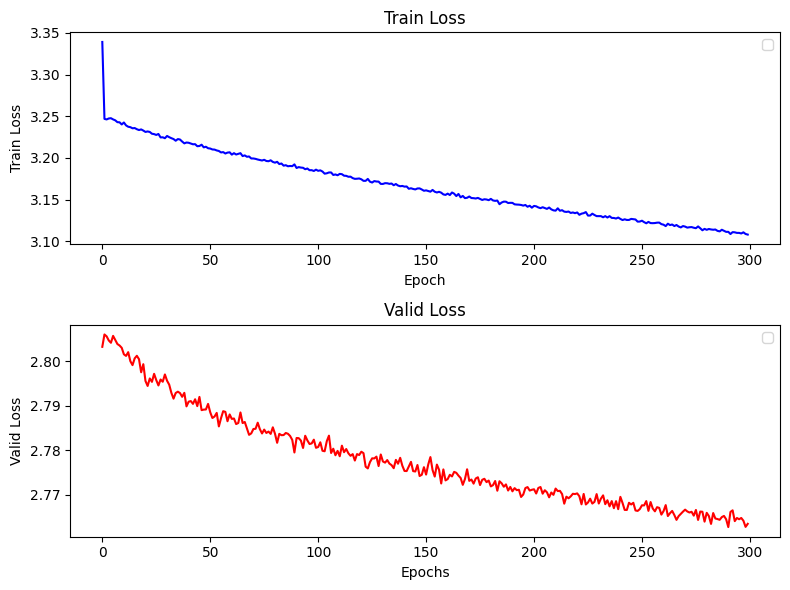

In [25]:
import matplotlib.pyplot as plt 


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Biểu đồ 1: Hàm sin
ax1.plot(trainer.loss['train'],  color='b')
ax1.set_title('Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss')
ax1.legend()

# Biểu đồ 2: Hàm cos
ax2.plot(trainer.loss['val'], color='r')
ax2.set_title('Valid Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Valid Loss')
ax2.legend()

# Hiển thị hai biểu đồ
plt.tight_layout()
plt.show()

In [34]:
# visualize 
word2vec = params[0]
word2vec[:100]

tensor([[ 0.1967, -0.2880,  0.3664,  ...,  0.2474, -0.3488, -0.8161],
        [-0.3361,  0.0489,  1.0301,  ...,  0.0946, -0.2020, -0.1725],
        [ 0.1677,  0.3040, -0.3116,  ...,  0.7066,  1.1035, -0.7082],
        ...,
        [ 1.1659, -0.4397, -0.5952,  ...,  0.7555,  0.2184, -0.7267],
        [ 0.2971, -0.4988, -0.2751,  ..., -0.5998,  0.1913, -0.4368],
        [-0.0750, -0.0238,  1.3943,  ..., -0.6747,  1.4508, -1.5680]],
       device='cuda:0', grad_fn=<SliceBackward0>)

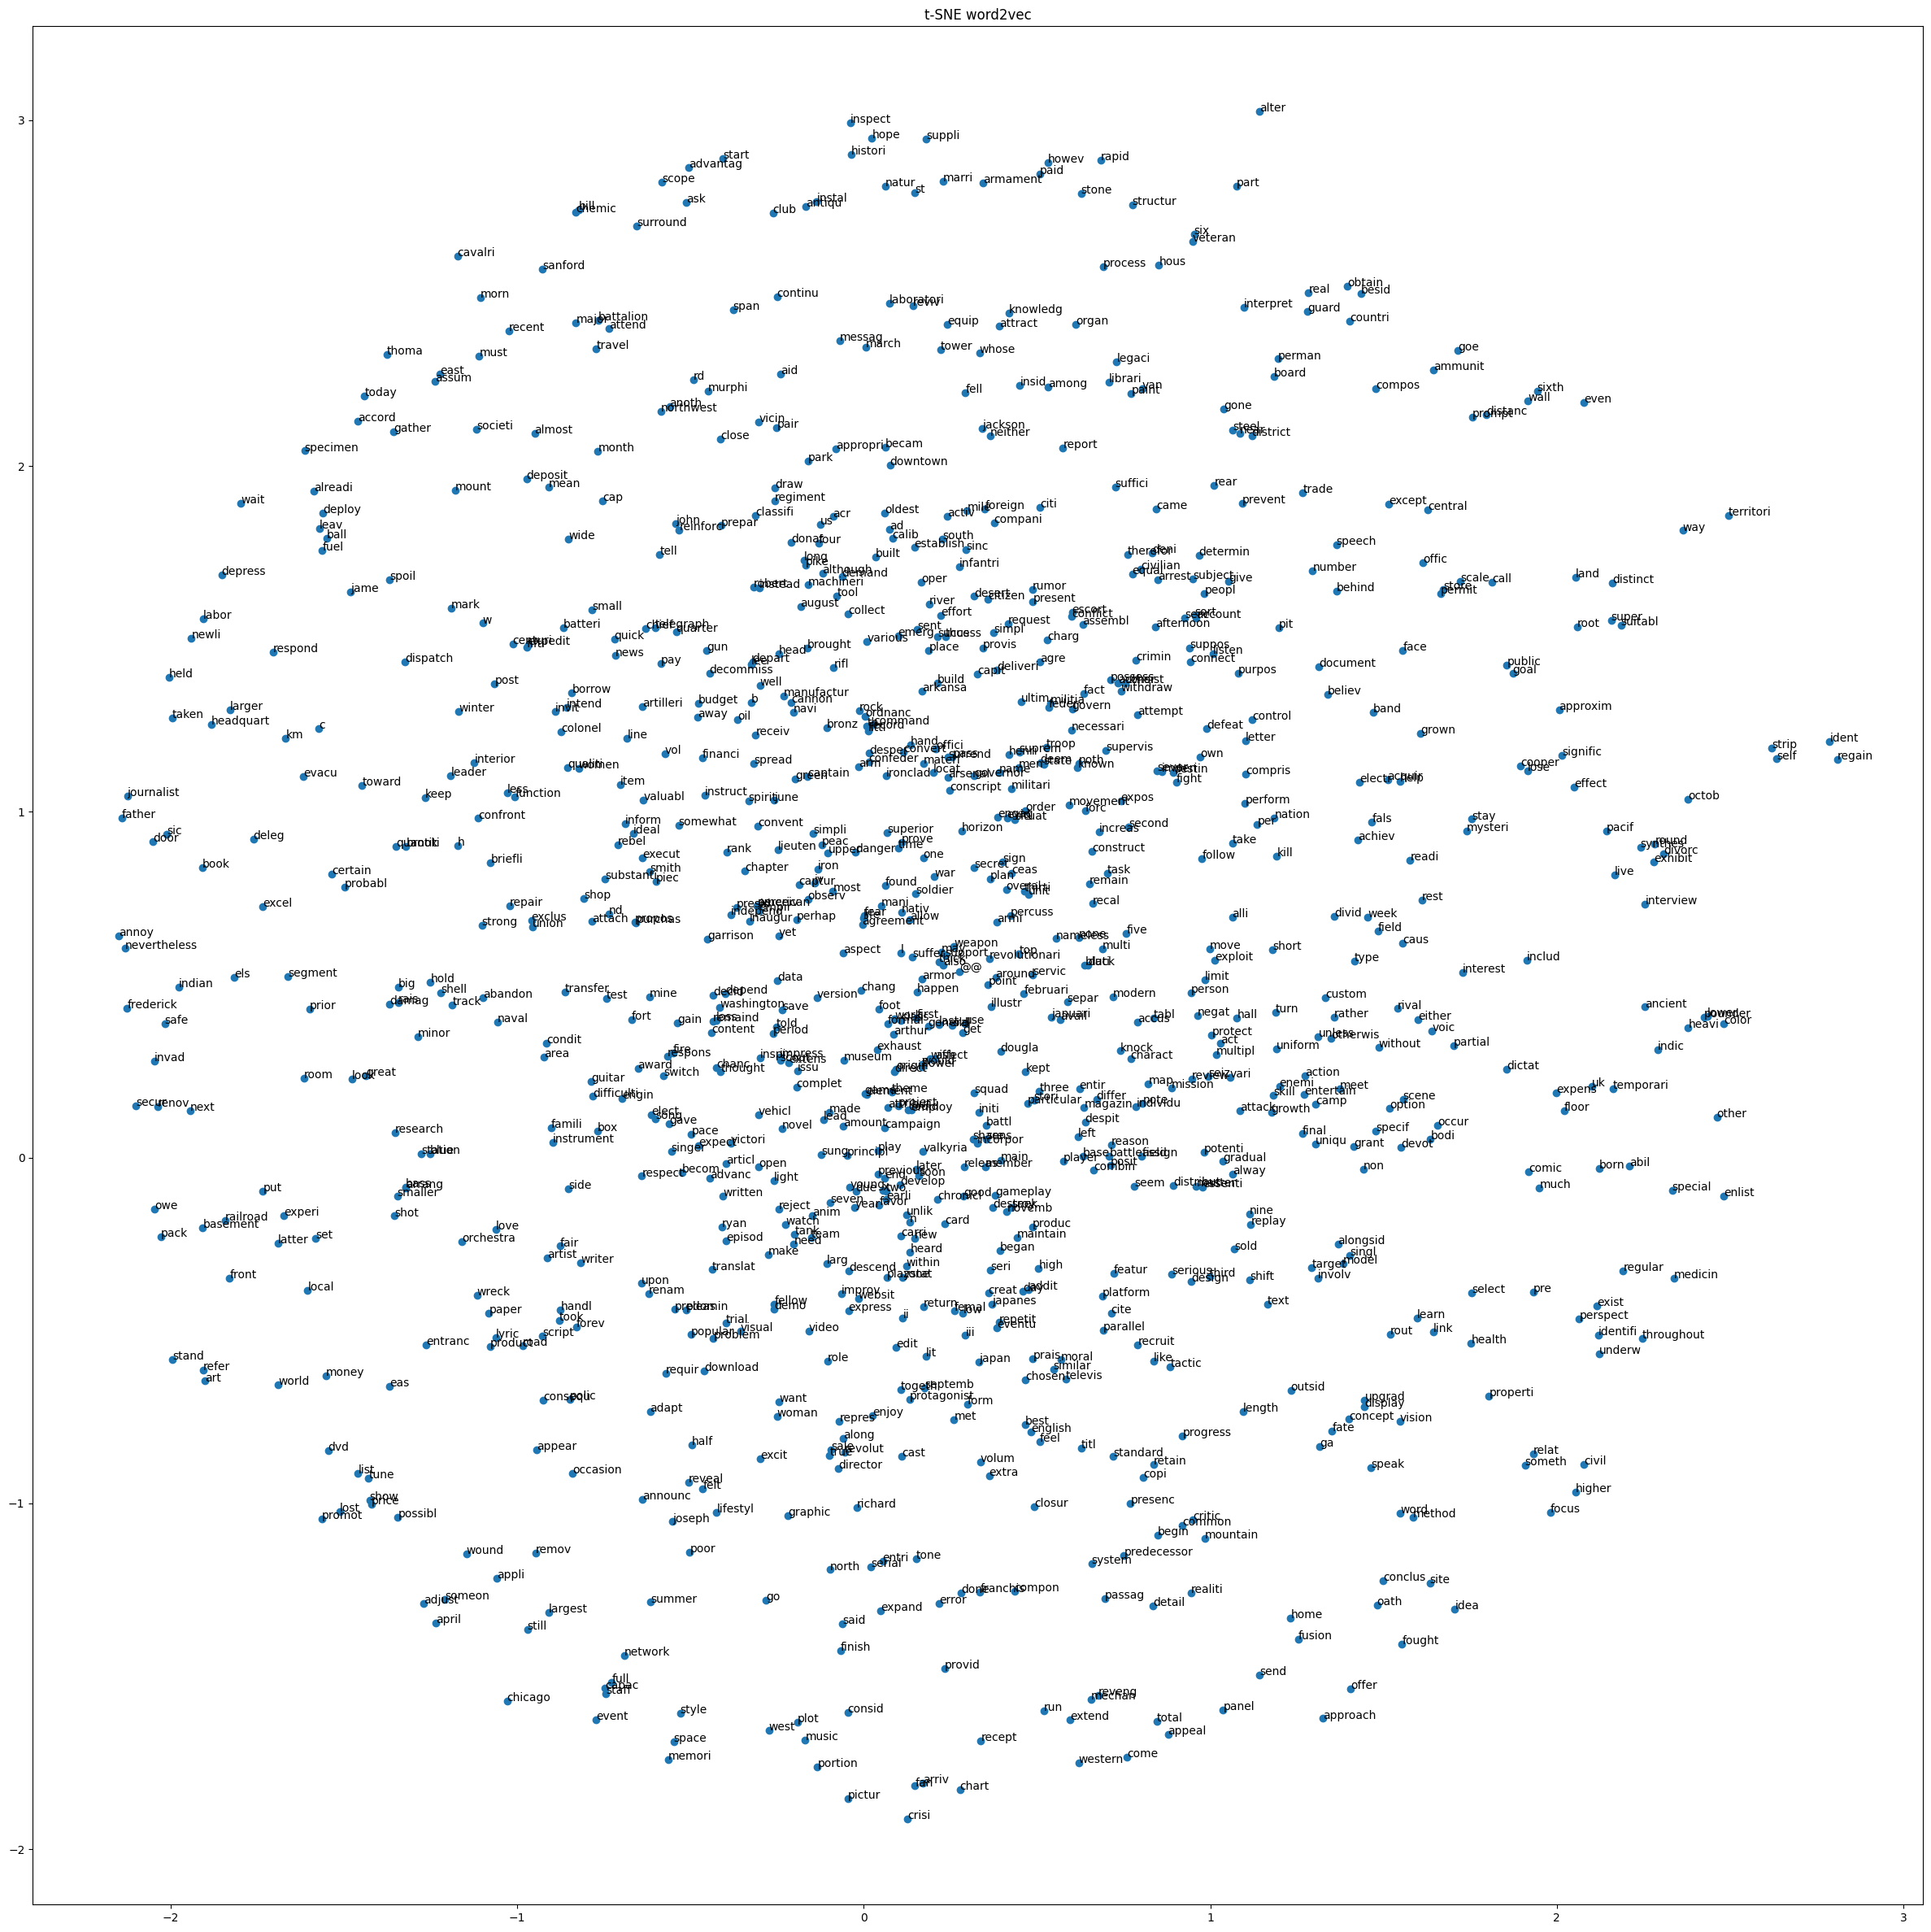

In [35]:
from sklearn.manifold import TSNE
import numpy as np

vectors = word2vec[:1000].cpu().detach().numpy()
tsne = TSNE(n_components=2)
vectors = tsne.fit_transform(vectors)

plt.figure(figsize=(30, 30))
plt.scatter(vectors[:, 0], vectors[:, 1])
for i, word in enumerate(vocab):
    if i >= 1000: break 
    plt.annotate(word, (vectors[i, 0], vectors[i, 1]))
plt.title("t-SNE word2vec")
plt.show()
